In [2]:
!pip install -q git+https://github.com/tensorflow/examples.git

In [131]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np

import tensorflow as tf
from tensorflow import keras

from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds

from IPython.display import display, clear_output
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.0.0', with_info=True)

Shuffling and writing examples to /Users/vlsnk/tensorflow_datasets/oxford_iiit_pet/3.0.0.incompleteM79ICY/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /Users/vlsnk/tensorflow_datasets/oxford_iiit_pet/3.0.0.incompleteM79ICY/oxford_iiit_pet-test.tfrecord



Dataset oxford_iiit_pet downloaded and prepared to /Users/vlsnk/tensorflow_datasets/oxford_iiit_pet/3.0.0. Subsequent calls will reuse this data.


In [3]:
# Preprocessing
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [4]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
        
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

In [5]:
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [6]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [7]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [9]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [137]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        if display_list[i].numpy().shape[-1] == 1:
            plt.imshow(display_list[i].numpy().reshape((128, 128)))
        else:
            plt.imshow(display_list[i].numpy())
        plt.axis('off')
    plt.show()

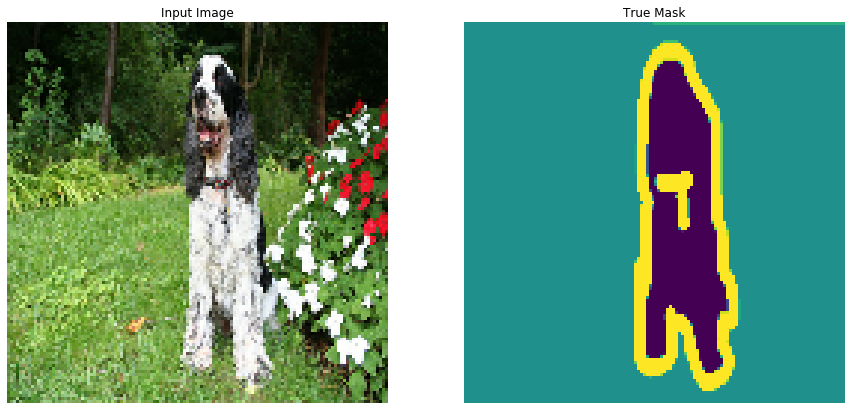

In [138]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [84]:
OUTPUT_CHANNELS = 3

In [101]:
base_model = keras.applications.MobileNetV2(input_shape=(128, 128, 3), include_top=False)

layer_names = [
    'block_1_expand_relu',    # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

down_stack = keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [109]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [125]:
def unet_model(output_channels):
    
    last = keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same', activation='softmax')
    
    inputs = keras.layers.Input(shape=(128, 128, 3))
    x = inputs
    
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])
    
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = keras.layers.Concatenate()
        x = concat([x, skip])
        
    x = last(x)
    
    return keras.Model(inputs=inputs, outputs=x)

In [126]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [127]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [148]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

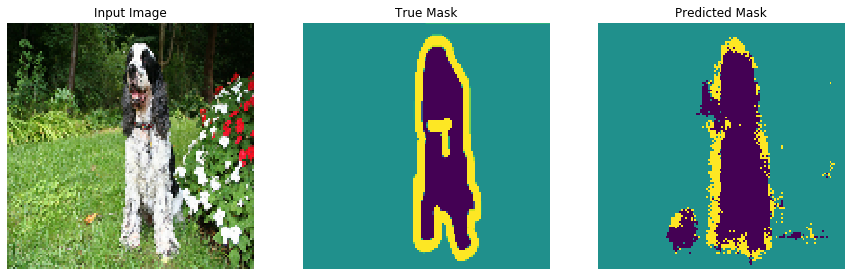

In [141]:
show_predictions()

In [142]:
class DisplayCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print('\nSample Prediction after epoch {}\n'.format(epoch+1))

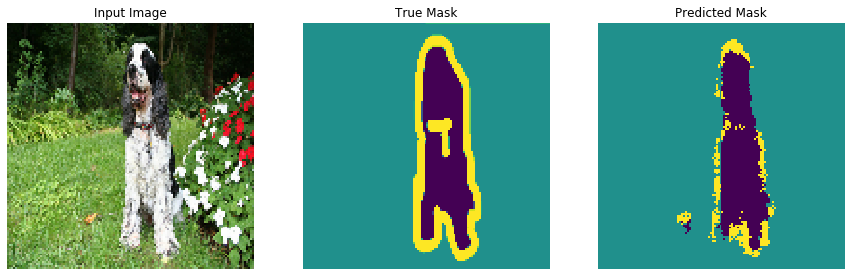


Sample Prediction after epoch 2

57/57 [==============================] - 188s 3s/step - loss: 0.2694 - accuracy: 0.8876 - val_loss: 0.3112 - val_accuracy: 0.8740


In [143]:
EPOCHS = 2
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

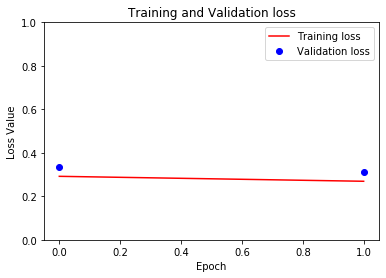

In [146]:
loss = model_history.history['loss']
var_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, var_loss, 'bo', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

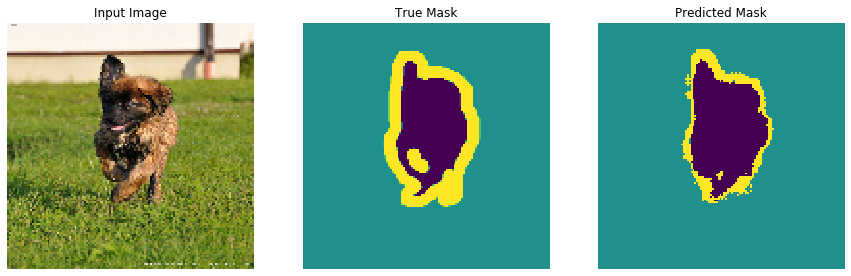

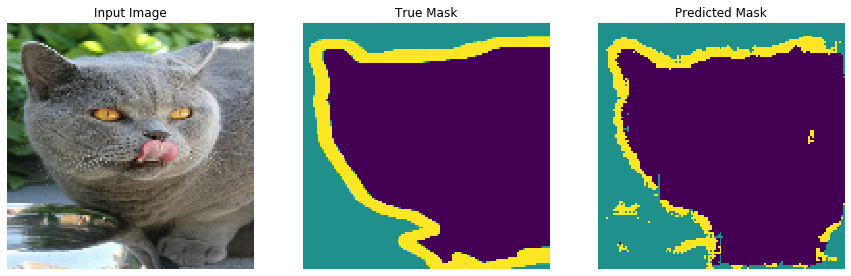

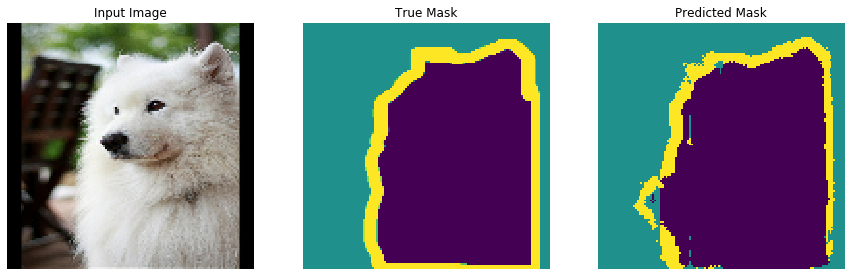

In [149]:
show_predictions(test_dataset, 3)